In [1]:
# Tải dữ liệu từ ISIC Challenge
!wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part1_GroundTruth.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Test_v2_Part1_GroundTruth.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Test_v2_Data.zip

--2025-01-23 10:54:05--  https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part1_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 16.182.36.129, 52.217.46.12, 3.5.27.46, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|16.182.36.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9321981 (8.9M) [application/zip]
Saving to: ‘ISIC-2017_Training_Part1_GroundTruth.zip’

ISIC-2017_Training_ 100%[===================>]   8.89M  16.1MB/s    in 0.6s    

2025-01-23 10:54:06 (16.1 MB/s) - ‘ISIC-2017_Training_Part1_GroundTruth.zip’ saved [9321981/9321981]

--2025-01-23 10:54:06--  https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Test_v2_Part1_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 3.5.29.48, 52.217.169.1, 52.216.29.196, ...
Connecting to isic-challenge-data.s3.amazonaws.com (is

In [2]:
# Giải nén và xóa tệp zip
!unzip -q ISIC-2017_Training_Part1_GroundTruth.zip -d ISIC-2017_Training_Part1_GroundTruth && rm ISIC-2017_Training_Part1_GroundTruth.zip
!unzip -q ISIC-2017_Test_v2_Part1_GroundTruth.zip -d ISIC-2017_Test_v2_Part1_GroundTruth && rm ISIC-2017_Test_v2_Part1_GroundTruth.zip
!unzip -q ISIC-2017_Training_Data.zip -d ISIC-2017_Training_Data && rm ISIC-2017_Training_Data.zip
!unzip -q ISIC-2017_Test_v2_Data.zip -d ISIC-2017_Test_v2_Data && rm ISIC-2017_Test_v2_Data.zip

In [3]:
# Cài đặt môi trường và clone mã nguồn TransUNet
!git clone https://github.com/Beckschen/TransUNet.git
%cd TransUNet

# Cài đặt các thư viện cần thiết
!pip install -r requirements.txt
!pip install tensorboardX medpy SimpleITK ml_collections

Cloning into 'TransUNet'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 119 (delta 65), reused 48 (delta 48), pack-reused 40 (from 2)
Receiving objects: 100% (119/119), 44.25 KiB | 4.92 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/kaggle/working/TransUNet
ERROR: Could not find a version that satisfies the requirement torch==1.4.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1)
ERROR: No matching distribution found for torch==1.4.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.9 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.5.2-cp310-cp310-linux_x86_64.whl size=762837 sha256=35cdf1957f8df12f17f1237eaf619d9879a13da837b16101

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

class ISICDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        mask_name = img_name.replace('.jpg', '_segmentation.png')
        mask_path = os.path.join(self.masks_dir, mask_name)
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

# Transform dữ liệu
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Tạo DataLoader
train_dataset = ISICDataset(
    '/kaggle/working/ISIC-2017_Training_Data/ISIC-2017_Training_Data',
    '/kaggle/working/ISIC-2017_Training_Part1_GroundTruth/ISIC-2017_Training_Part1_GroundTruth',
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = ISICDataset(
    '/kaggle/working/ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data',
    '/kaggle/working/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC-2017_Test_v2_Part1_GroundTruth',
    transform=transform
)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [9]:
!wget https://storage.googleapis.com/vit_models/imagenet21k/R50%2BViT-B_16.npz -O R50+ViT-B_16.npz
!mkdir -p model/vit_checkpoint/imagenet21k
!mv R50+ViT-B_16.npz model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz

--2025-01-23 11:10:27--  https://storage.googleapis.com/vit_models/imagenet21k/R50%2BViT-B_16.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.207, 74.125.142.207, 108.177.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 461217452 (440M) [application/octet-stream]
Saving to: ‘R50+ViT-B_16.npz’

R50+ViT-B_16.npz    100%[===================>] 439.85M  26.6MB/s    in 17s     

2025-01-23 11:10:45 (25.8 MB/s) - ‘R50+ViT-B_16.npz’ saved [461217452/461217452]



In [10]:
import torch
from networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
from networks.vit_seg_modeling import VisionTransformer as ViT_seg
import numpy as np

# Cấu hình mô hình
config_vit = CONFIGS_ViT_seg['R50-ViT-B_16']
config_vit.n_classes = 1  # Lớp đầu ra
config_vit.n_skip = 3
config_vit.patches.grid = (int(224 / 16), int(224 / 16))

# Khởi tạo mô hình
model = ViT_seg(config_vit, img_size=224, num_classes=config_vit.n_classes)
model.load_from(weights=np.load('model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz'))

# Chuyển mô hình sang GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (hybrid_model): ResNetV2(
        (root): Sequential(
          (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (gn): GroupNorm(32, 64, eps=1e-06, affine=True)
          (relu): ReLU(inplace=True)
        )
        (body): Sequential(
          (block1): Sequential(
            (unit1): PreActBottleneck(
              (gn1): GroupNorm(32, 64, eps=1e-06, affine=True)
              (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (gn2): GroupNorm(32, 64, eps=1e-06, affine=True)
              (conv2): StdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (gn3): GroupNorm(32, 256, eps=1e-06, affine=True)
              (conv3): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (relu): ReLU(inplace=True)
              (downsample): StdConv2d(64, 256, 

In [11]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Optimizer

In [12]:
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')

    # Validation
    val_loss = 0.0
    with torch.no_grad():
        model.eval()
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}')

# Lưu mô hình
torch.save(model.state_dict(), '/kaggle/working/transunet_model.pth')

Epoch 1/15, Train Loss: 0.2948
Epoch 1/15, Val Loss: 0.2523
Epoch 2/15, Train Loss: 0.1542
Epoch 2/15, Val Loss: 0.2059
Epoch 3/15, Train Loss: 0.1127
Epoch 3/15, Val Loss: 0.2041
Epoch 4/15, Train Loss: 0.0896
Epoch 4/15, Val Loss: 0.1902
Epoch 5/15, Train Loss: 0.0744
Epoch 5/15, Val Loss: 0.1921
Epoch 6/15, Train Loss: 0.0663
Epoch 6/15, Val Loss: 0.1953
Epoch 7/15, Train Loss: 0.0585
Epoch 7/15, Val Loss: 0.2246
Epoch 8/15, Train Loss: 0.0534
Epoch 8/15, Val Loss: 0.2086
Epoch 9/15, Train Loss: 0.0516
Epoch 9/15, Val Loss: 0.2306
Epoch 10/15, Train Loss: 0.0458
Epoch 10/15, Val Loss: 0.2040
Epoch 11/15, Train Loss: 0.0396
Epoch 11/15, Val Loss: 0.2659
Epoch 12/15, Train Loss: 0.0369
Epoch 12/15, Val Loss: 0.3239
Epoch 13/15, Train Loss: 0.0341
Epoch 13/15, Val Loss: 0.2806
Epoch 14/15, Train Loss: 0.0323
Epoch 14/15, Val Loss: 0.3158
Epoch 15/15, Train Loss: 0.0301
Epoch 15/15, Val Loss: 0.2821


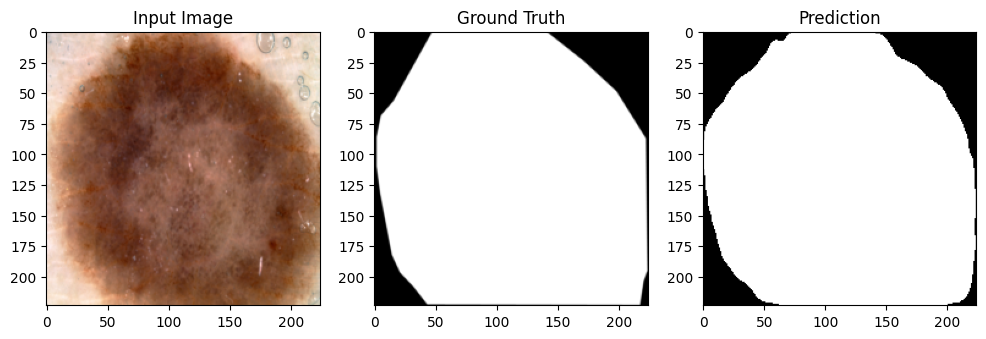

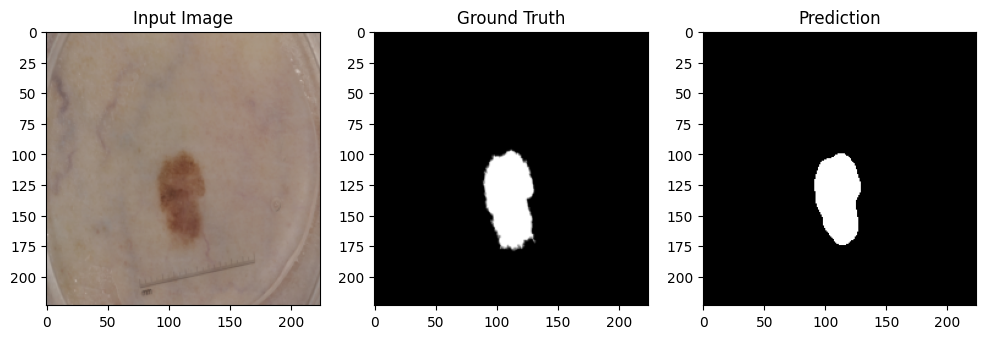

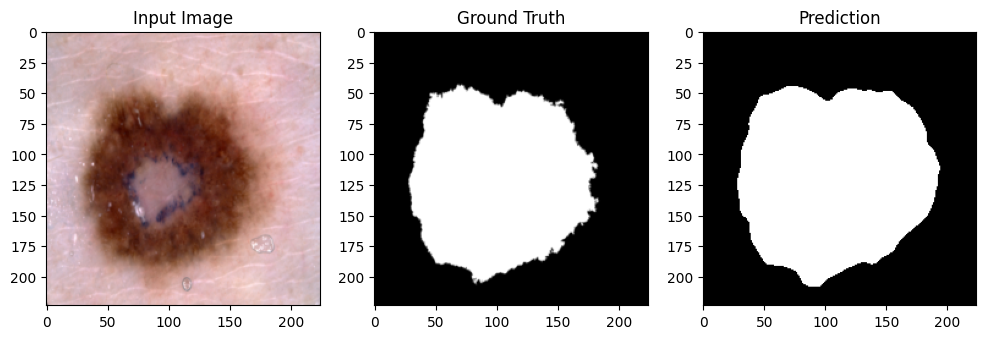

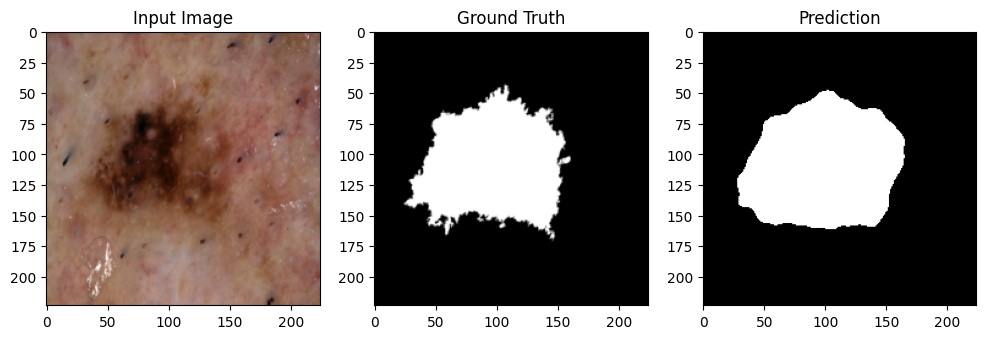

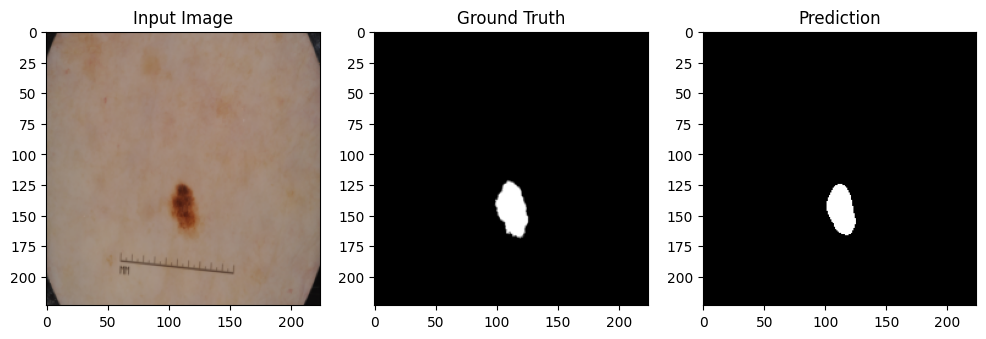

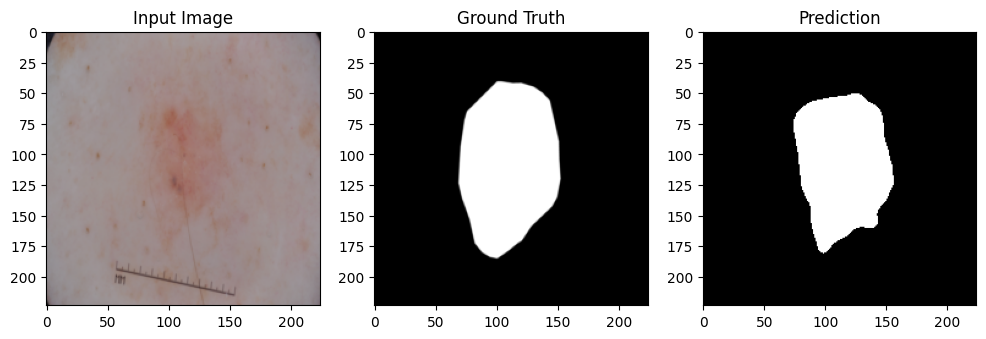

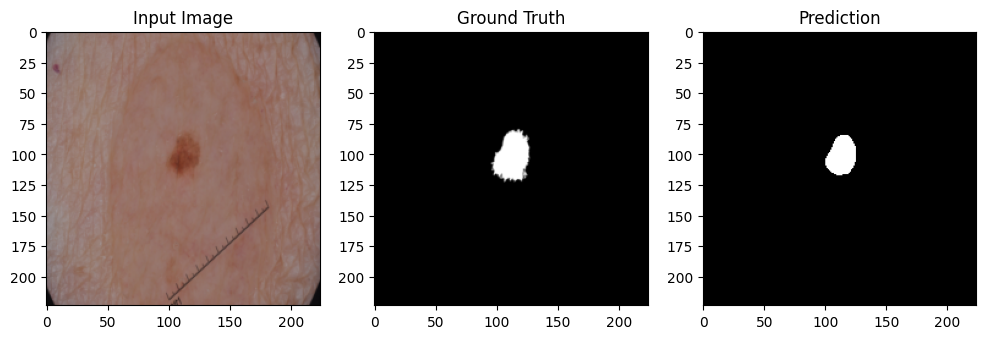

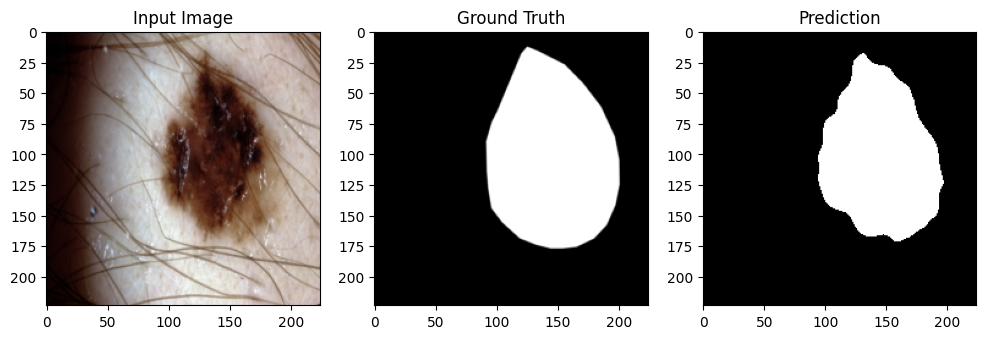

In [13]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = torch.sigmoid(model(images)) > 0.5

        for i in range(len(images)):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.title("Input Image")
            plt.imshow(images[i].cpu().permute(1, 2, 0))

            plt.subplot(1, 3, 2)
            plt.title("Ground Truth")
            plt.imshow(masks[i].cpu().squeeze(), cmap='gray')

            plt.subplot(1, 3, 3)
            plt.title("Prediction")
            plt.imshow(outputs[i].cpu().squeeze(), cmap='gray')

            plt.show()
        break